<div align="center">

## Project: Discovering an Algebraic Structure through Neural Network Learning

</div>

In [1]:
from __future__ import print_function
import argparse
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as tc
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

####  Implementation of the Neural Network for the Morphism class that goes from $\mathbb{R}$ to the variety V

In [2]:
class Morphism(nn.Module):
    def __init__ (self, name = 'Morphisme R^n --> E', dim_E = 1, neurons = 6):
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(Morphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)

        # dropout layer
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

#### Implementation of the Neural Network for the Inverse_Morphism class that goes from the variety V to $\mathbb{R}$

In [3]:
class InverseMorphism(nn.Module):
    def __init__ (self, name = 'Inverse E --> R^n', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(InverseMorphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3= nn.Linear(neurons, neurons)
        
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

#### Implementation of the Neural Network for the operator $\oplus$

In [4]:
class LoiBinaire(nn.Module):
    def __init__ (self, name = 'Loi binaire ExE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiBinaire, self).__init__()
        # layers for plus : ExE --> E
        self.fc1 = nn.Linear(2 * dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x, y):
        z = torch.cat([x,y], axis=1) # [K,d], [K,d] ---> [K, 2*d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output
# scalaire product of structure

#### Implementation of the Neural Network for the operator $\odot$

In [5]:
class LoiScalaire(nn.Module):
    def __init__ (self, name = 'Loi Scalaire RxE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiScalaire, self).__init__()
        # layers for scaler : KxE --> E
        

        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
        
        # alpha est un  scalaire,  dim_E est la dimension de l'espace E
        
    def forward(self, alpha, x):
        z = alpha * x # [K,1], [K,d] ---> [K, d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output

#### Implementation of the Vector Space class containing the applications and training of the quadruplet ($\oplus$, $\odot$, $f$, $f^{-1}$)

In [6]:
class Vect_space(nn.Module):
    def __init__ (self, K,  dim_E = 1 , neurons = 6 , name = 'Groupe (E,+)'):
        super(Vect_space, self).__init__()
        self.f    = Morphism(dim_E = dim_E, neurons = neurons)
        self.fi   = InverseMorphism(dim_E = dim_E, neurons = neurons)
        self.plus = LoiBinaire(dim_E = dim_E, neurons = neurons)
        self.scalaire = LoiScalaire(dim_E = dim_E, neurons = neurons)
        # losses
        self.loss_1 = lambda x, y : torch.linalg.vector_norm(self.plus(x , y) - self.f( self.fi(x) + self.fi(y)) )**2
        self.loss_2 = lambda alpha, x : torch.linalg.vector_norm(self.scalaire(alpha , x) - self.f( alpha*self.fi(x)) )**2

        #  Total loss can be weighted 
        self.loss = lambda x, y, alpha : self.loss_1(x, y) + self.loss_2(alpha, x)
        
    def train(self, X, Y, alpha, optimizer, epoch):
        self.f.train()
        self.fi.train()
        self.plus.train()
        self.scalaire.train()
        losses=[]
        for i in range(epoch):
            L1 = self.loss_1(X, Y)
            L2 = self.loss_2(alpha, X)
            loss = L1 + L2
            #loss = loss.mean()
            if i % 200 == 0:
                print('Epoch {}/{} -\t Loss 1: {:.6f}\t Loss 2: {:.6f}\t Total Loss: {:.6f}'.format(i, epoch, L1.item(), L2.item(), loss.item()))
            
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        return losses

In [7]:
def line(K, epsilon):
    X = torch.rand(K, 2).requires_grad_(False)
    X[K//2:] *= -1
    Y = torch.randn(K, 2).requires_grad_(False)
    Y[K//2:] *= -1
    alpha = torch.randn(K, 1).requires_grad_(False)
    X[:,1] = X[:,0] + epsilon * torch.sin(X[:,0] / epsilon)
    Y[:,1] = Y[:,0] + epsilon * torch.sin(Y[:,0] / epsilon)
    return X, Y, alpha

#### Presentation of Results after Training

[Model] name : Morphisme R^n --> E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Inverse E --> R^n
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi binaire ExE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi Scalaire RxE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
Epoch 0/1000 -	 Loss 1: 64.398994	 Loss 2: 154.615189	 Total Loss: 219.014191
Epoch 200/1000 -	 Loss 1: 19.900482	 Loss 2: 32.650211	 Total Loss: 52.550694
Epoch 400/1000 -	 Loss 1: 1.201545	 Loss 2: 1.176576	 Total Loss: 2.378121
Epoch 600/1000 -	 Loss 1: 0.115301	 Loss 2: 0.062115	 Total Loss: 0.177416
Epoch 800/1000 -	 Loss 1: 0.079808	 Loss 2: 0.018710	 Total Loss: 0.098518


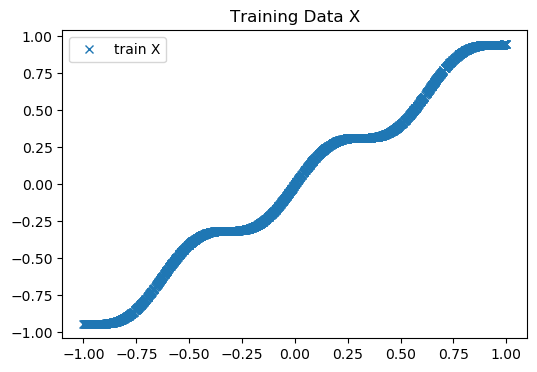

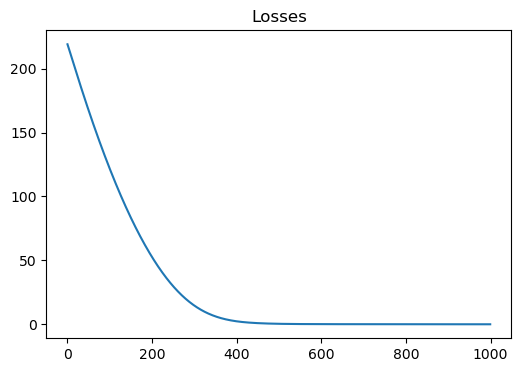

In [8]:
K = 2000
epislon = 0.1

X,Y,alpha = line(K, epislon)
dim = 2

# on initialise le vecteur space
G = Vect_space(K, dim_E = dim, neurons = 64)
# on initialise l'optimiseur

optimizer = optim.Adadelta(list(G.parameters()), lr=1e-3)
# la loss
losses = G.train(X,Y, alpha, optimizer, 1000)

plt.figure(figsize=(6, 4))
plt.plot(X[:,0], X[:,1], 'x', label='train X')
plt.title('Training Data X')
plt.legend()
plt.show()



# on affiche la loss 
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title('Losses')
plt.show()

In [9]:
K = 10
B = 0.3*torch.randn((K, 2))
C = 0.3*torch.randn((K, 2))
alpha = torch.randn((K, 1))

# Générer une valeur aléatoire pour B[0,0]
for i in range(K):
    B[i,1] = B[i,0] + epislon * torch.sin(B[i,0] / epislon )
    C[i,1] = C[i,0] + epislon * torch.sin(C[i,0] / epislon )

B, C

(tensor([[ 0.2548,  0.3107],
         [ 0.1583,  0.2583],
         [ 0.3013,  0.3141],
         [-0.3634, -0.3161],
         [-0.2632, -0.3120],
         [-0.0913, -0.1704],
         [ 0.2034,  0.2929],
         [ 0.2009,  0.2915],
         [ 0.0938,  0.1744],
         [-0.0450, -0.0885]]),
 tensor([[-0.4941, -0.3967],
         [-0.3150, -0.3142],
         [ 0.1305,  0.2271],
         [-0.3673, -0.3166],
         [ 0.5296,  0.4461],
         [-0.0883, -0.1656],
         [ 0.2274,  0.3037],
         [ 0.5546,  0.4873],
         [-0.0511, -0.1000],
         [ 0.0534,  0.1043]]))

In [10]:
import pandas as pd
# Convert B and C to numpy arrays
# Convert B and C to numpy arrays
B_np = B.numpy()
C_np = C.numpy()
alpha_np = alpha.numpy()

# Create a DataFrame
df = pd.DataFrame({
    'B_x': B_np[:, 0],
    'B_y': B_np[:, 1],
    'C_x': C_np[:, 0],
    'C_y': C_np[:, 1],
    'alpha': alpha_np[:, 0]
})

print(df)



        B_x       B_y       C_x       C_y     alpha
0  0.254787  0.310732 -0.494112 -0.396716 -0.692384
1  0.158303  0.258295 -0.314981 -0.314159  0.829766
2  0.301324  0.314124  0.130550  0.227051  0.115896
3 -0.363401 -0.316125 -0.367259 -0.316620 -1.204961
4 -0.263195 -0.311982  0.529585  0.446129  0.306236
5 -0.091298 -0.170431 -0.088320 -0.165597  0.082018
6  0.203422  0.292875  0.227392  0.303675 -0.530621
7  0.200938  0.291474  0.554558  0.487307 -0.434485
8  0.093787  0.174417 -0.051113 -0.100029 -0.585744
9 -0.044993 -0.088484  0.053379  0.104259 -0.046212


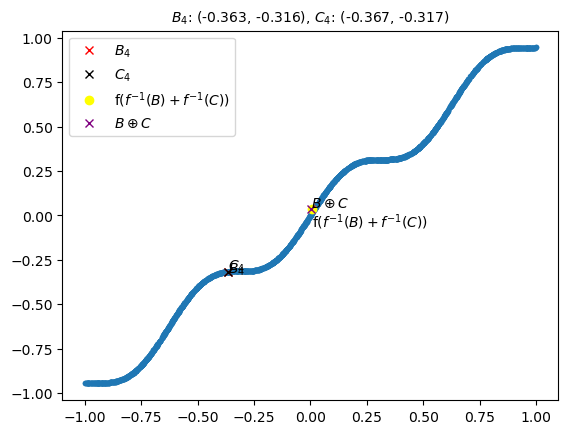

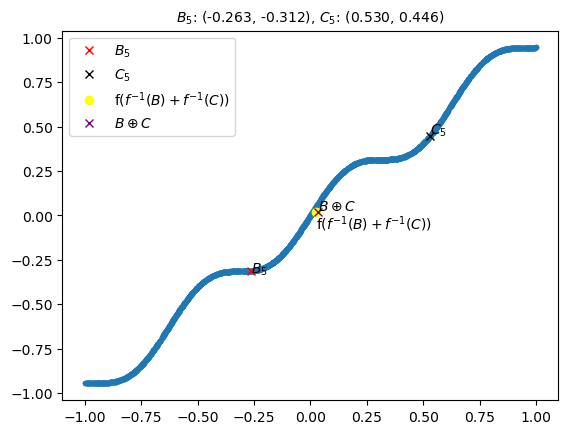

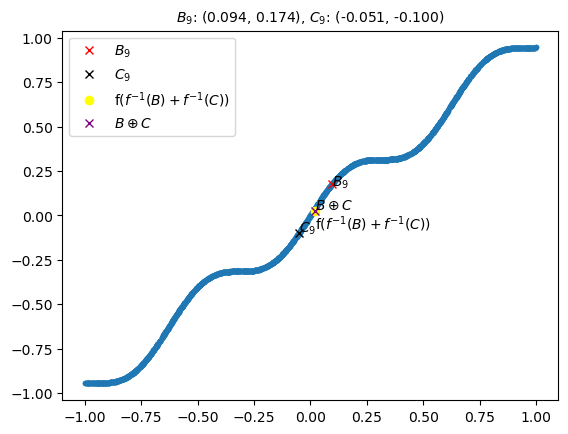

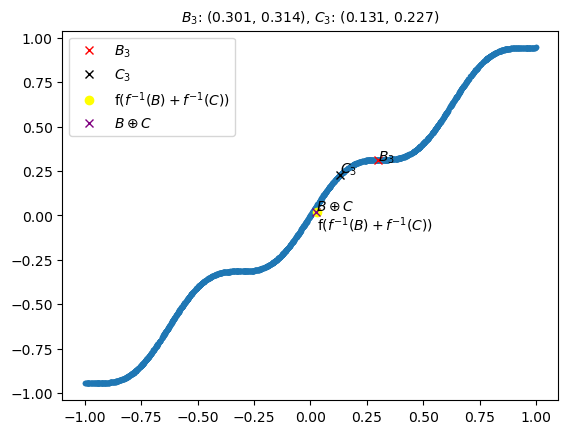

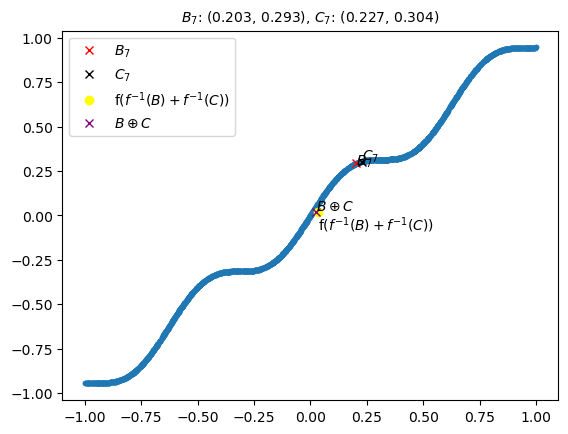

In [11]:


XXBC =  G.f(G.fi(B) + G.fi(C))
YYBC = G.plus(B, C)


indice = random.sample(range(B.shape[0]),5)
for i in indice:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], '.', linewidth = 0.01) 
    plt.plot(B[i, 0], B[i, 1],   'x', color='red',  label=r'$B_{' + str(i+1) + '}$')  
    plt.annotate(r'$B_{' + str(i+1) + '}$', (B[i, 0], B[i, 1] - 0.01))
    plt.plot(C[i, 0], C[i, 1], 'x',  color='black', label=r'$C_{' + str(i+1) + '}$', )
    plt.annotate(r'$C_{' + str(i+1) + '}$', (C[i, 0], C[i, 1] + 0.01))
    # Tracer le point XXBC[i]
    plt.plot(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), 'o', color='yellow', label=r'f($f^{-1}(B) + f^{-1}(C)$)')
    plt.annotate(r'f($f^{-1}(B) + f^{-1}(C)$)', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

    # Tracer le point YYBC[i]
    plt.plot(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), 'x', color='purple', label=r'$B \oplus C$')
    plt.annotate(r'$B \oplus C$', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
    # Ajouter une légende au subplot    

    plt.title(r'$B_{' + str(i+1) + '}$' + f': ({B[i, 0]:.3f}, {B[i, 1]:.3f}), ' + r'$C_{' + str(i+1) + '}$' + f': ({C[i, 0]:.3f}, {C[i, 1]:.3f})', fontsize=10)
    plt.legend()
    plt.show()

In [12]:
XXBC =  G.f(G.fi(B) + G.fi(C))

YYBC = G.plus(B, C)

XXBC_list = [x.detach().numpy() for x in XXBC]
YYBC_list = [y.detach().numpy() for y in YYBC]

# Calculer l'erreur pour chaque couple et la stocker dans une liste
erreur_list_l2 = [torch.norm(XXBC[i] - YYBC[i], p=2).item() for i in range(len(XXBC))]
erreur_list_inf = [torch.norm(XXBC[i] - YYBC[i], p=float('inf')).item() for i in range(len(XXBC))]


# Convertir les erreurs en notation scientifique
erreur_list_l2 = ['{:.1e}'.format(erreur) for erreur in erreur_list_l2]
erreur_list_inf = ['{:.1e}'.format(erreur) for erreur in erreur_list_inf]


# Ajouter les listes comme nouvelles colonnes dans le DataFrame
df['f.fi(B) + f.fi(C)'] = XXBC_list
df['B⊕C'] = YYBC_list
# Ajouter la colonne 'Erreur' à la fin du DataFrame
df['L^2 erreur'] = erreur_list_l2
df['inf erreur'] = erreur_list_inf

df






,B_x,B_y,C_x,C_y,alpha,f.fi(B) + f.fi(C),B⊕C,L^2 erreur,inf erreur
0,0.254787,0.310732,-0.494112,-0.396716,-0.692384,"[0.018386252, 0.026709855]","[0.011815049, 0.02712351]",6.6e-03,6.6e-03
1,0.158303,0.258295,-0.314981,-0.314159,0.829766,"[0.01938117, 0.026009932]","[0.016084157, 0.025779247]",3.3e-03,3.3e-03
2,0.301324,0.314124,0.130550,0.227051,0.115896,"[0.031263757, 0.017628781]","[0.026746534, 0.017078295]",4.6e-03,4.5e-03
3,-0.363401,-0.316125,-0.367259,-0.316620,-1.204961,"[0.007860195, 0.034135774]","[0.0036249012, 0.033898674]",4.2e-03,4.2e-03
4,-0.263195,-0.311982,0.529585,0.446129,0.306236,"[0.024923496, 0.022108898]","[0.031755336, 0.017708361]",8.1e-03,6.8e-03
5,-0.091298,-0.170431,-0.088320,-0.165597,0.082018,"[0.015696343, 0.028617658]","[0.023178115, 0.023728736]",8.9e-03,7.5e-03
6,0.203422,0.292875,0.227392,0.303675,-0.530621,"[0.031950276, 0.017142646]","[0.025513388, 0.017803125]",6.5e-03,6.4e-03
7,0.200938,0.291474,0.554558,0.487307,-0.434485,"[0.036660284, 0.0138255805]","[0.037686884, 0.01219774]",1.9e-03,1.6e-03
8,0.093787,0.174417,-0.051113,-0.100029,-0.585744,"[0.022503383, 0.023810193]","[0.022579111, 0.022408076]",1.4e-03,1.4e-03
9,-0.044993,-0.088484,0.053379,0.104259,-0.046212,"[0.021512277, 0.024510033]","[0.021187134, 0.022302024]",2.2e-03,2.2e-03


#### Let's implement a test with Pytest to verify that the errors are less than 0.01 for the property $f(f^{-1}(B) + f^{-1}(C))$

In [13]:
assert all(float(erreur) <= 0.01 for erreur in erreur_list_l2), "Au moins une erreur L^2 est supérieure à 0.01"
assert all(float(erreur) <= 0.01 for erreur in erreur_list_inf), "Au moins une erreur inf est supérieure à 0.01"

#### The results for the  f($\alpha \cdot f^{-1}(B)$)   and   $\alpha \odot B$

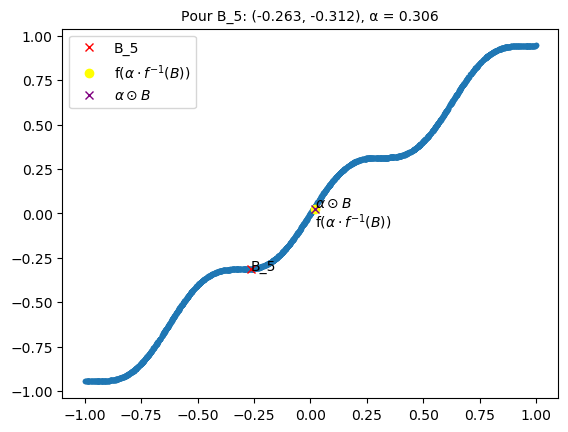

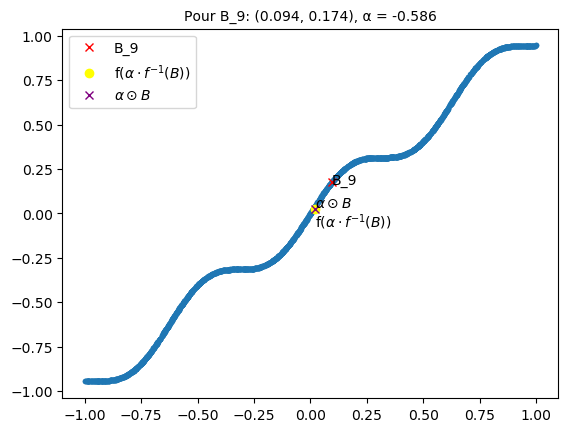

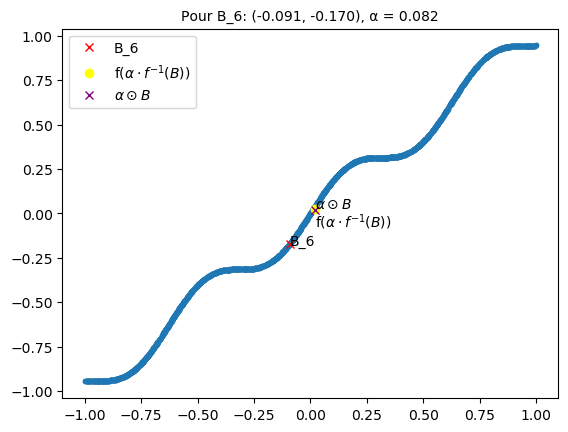

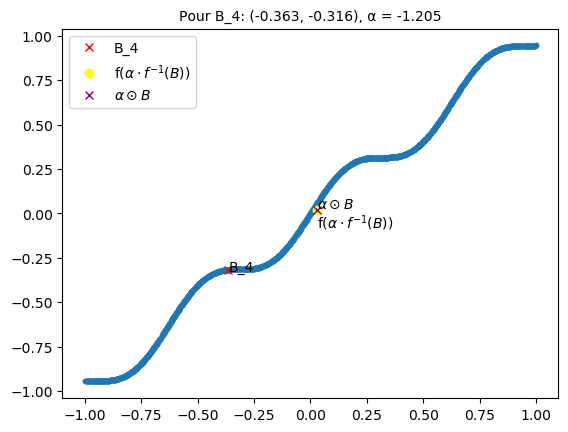

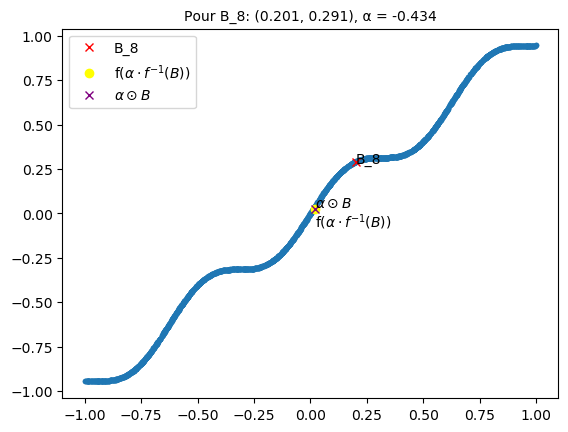

In [14]:

XXBC =  G.f(alpha * G.fi(B))

YYBC = G.scalaire(alpha, B)
indice = random.sample(range(B.shape[0]),5)

for i in indice:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], '.', linewidth = 0.01) 
    plt.plot(B[i, 0], B[i, 1],   'x', color='red',  label=f'B_{i+1}')  
    plt.annotate(f'B_{i+1}', (B[i, 0], B[i, 1] - 0.01))
    # Tracer le point XXBC[i]
    plt.plot(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), 'o', color='yellow', label=r'f($\alpha \cdot f^{-1}(B)$)')
    plt.annotate(r'f($\alpha \cdot f^{-1}(B)$)', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

    # Tracer le point YYBC[i]
    plt.plot(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), 'x', color='purple', label=r'$\alpha \odot B$')
    plt.annotate(r'$\alpha \odot B$', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
    # Ajouter une légende au subplot    
    plt.title(f'Pour B_{i+1}: ({B[i, 0].item():.3f}, {B[i, 1].item():.3f}), α = {alpha[i].item():.3f}', fontsize=10)
    plt.legend()
    plt.show()

In [15]:
XXBC =  G.f(alpha *G.fi(B))

YYBC = G.scalaire(alpha, B)


XXBC_list = [x.detach().numpy() for x in XXBC]
YYBC_list = [y.detach().numpy() for y in YYBC]

# Calculer l'erreur pour chaque couple et la stocker dans une liste
erreur_list_l2 = [torch.norm(XXBC[i] - YYBC[i], p=2).item() for i in range(len(XXBC))]
erreur_list_inf = [torch.norm(XXBC[i] - YYBC[i], p=float('inf')).item() for i in range(len(XXBC))]


# Convertir les erreurs en notation scientifique
erreur_list_l2 = ['{:.1e}'.format(erreur) for erreur in erreur_list_l2]
erreur_list_inf = ['{:.1e}'.format(erreur) for erreur in erreur_list_inf]


# Ajouter les listes comme nouvelles colonnes dans le DataFrame
df['f(alpha . fi(B))'] = XXBC_list
df['B⊙C'] = YYBC_list
# Ajouter la colonne 'Erreur' à la fin du DataFrame
df['L^2 erreur'] = erreur_list_l2
df['inf erreur'] = erreur_list_inf



frame = df[['B_x', 'B_y', 'L^2 erreur', 'inf erreur', 'B⊙C', 'f(alpha . fi(B))']]


frame = df[['B_x', 'B_y', 'B⊙C', 'f(alpha . fi(B))', 'L^2 erreur', 'inf erreur']]

frame



,B_x,B_y,B⊙C,f(alpha . fi(B)),L^2 erreur,inf erreur
0,0.254787,0.310732,"[0.018157378, 0.024959363]","[0.01733886, 0.026579306]",1.8e-03,1.6e-03
1,0.158303,0.258295,"[0.024975985, 0.017440967]","[0.024965094, 0.021691486]",4.3e-03,4.3e-03
2,0.301324,0.314124,"[0.022631332, 0.020966418]","[0.022040932, 0.023524508]",2.6e-03,2.6e-03
3,-0.363401,-0.316125,"[0.030513048, 0.016999148]","[0.029420987, 0.017891623]",1.4e-03,1.1e-03
4,-0.263195,-0.311982,"[0.020212427, 0.022999078]","[0.019516278, 0.02536761]",2.5e-03,2.4e-03
5,-0.091298,-0.170431,"[0.02173394, 0.021765113]","[0.021093674, 0.02418188]",2.5e-03,2.4e-03
6,0.203422,0.292875,"[0.019502386, 0.024252854]","[0.018593222, 0.02574753]",1.7e-03,1.5e-03
7,0.200938,0.291474,"[0.019959413, 0.02374956]","[0.019104399, 0.025418006]",1.9e-03,1.7e-03
8,0.093787,0.174417,"[0.020577215, 0.023517132]","[0.019658832, 0.024978034]",1.7e-03,1.5e-03
9,-0.044993,-0.088484,"[0.021968544, 0.021404125]","[0.02139657, 0.023926206]",2.6e-03,2.5e-03


#### Let's implement a test with Pytest to verify that the errors are less than 0.01 for the property $f(\alpha \cdot f^{-1}(B))$

In [16]:

assert all(float(erreur) <= 0.01 for erreur in erreur_list_l2), "Au moins une erreur L^2 est supérieure à 0.01"
assert all(float(erreur) <= 0.01 for erreur in erreur_list_inf), "Au moins une erreur inf est supérieure à 0.01"

#### Here we have done the whole test with the first and second proprieties choosing $\alpha$ between -5 and 5

[Model] name : Morphisme R^n --> E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Inverse E --> R^n
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi binaire ExE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi Scalaire RxE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
Epoch 0/1000 -	 Loss 1: 194.998810	 Loss 2: 38.344528	 Total Loss: 233.343338
Epoch 200/1000 -	 Loss 1: 49.653957	 Loss 2: 4.931204	 Total Loss: 54.585159
Epoch 400/1000 -	 Loss 1: 1.339946	 Loss 2: 0.218689	 Total Loss: 1.558635
Epoch 600/1000 -	 Loss 1: 0.009982	 Loss 2: 0.053382	 Total Loss: 0.063364
Epoch 800/1000 -	 Loss 1: 0.011850	 Loss 2: 0.024710	 Total Loss: 0.036560


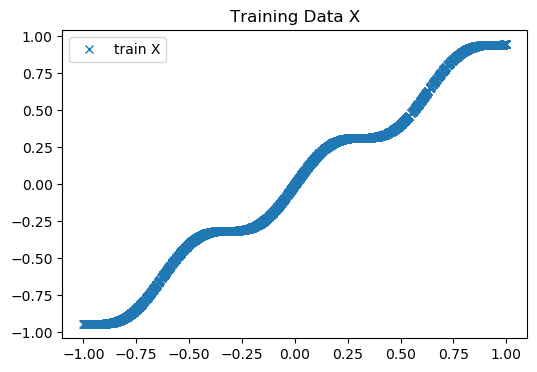

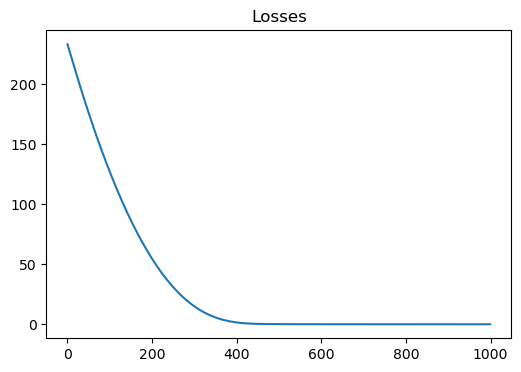

Les données Test pour tester le modèle
        B_x       B_y       C_x       C_y     alpha
0 -0.349766 -0.314907  0.273307  0.313032 -1.141407
1 -0.365715 -0.316413  0.026158  0.052019  0.534529
2  0.093530  0.174007  0.344262  0.314612  1.411817
3 -0.261701 -0.311786  0.372111  0.317349 -0.240664
4  0.275395  0.313196 -0.659730 -0.690628  0.259807
5  0.214699  0.298553 -0.009391 -0.018768 -0.761469
6 -0.574326 -0.522919 -0.147053 -0.246551  0.988814
7  0.183209  0.279815 -0.409628 -0.328015 -0.537301
8 -0.515565 -0.425230 -0.171933 -0.270832 -0.875471
9 -0.225550 -0.303011  0.002103  0.004205 -0.069002
resultat obtenu pour le test de la première propriété du théorème
     f($f^{-1}(B) + f^{-1}(C)$)                         B ⊕ C L^2 erreur  \
0  [-0.0064813197, 0.023791295]   [-0.006585691, 0.022299781]    1.5e-03   
1  [-0.0108731985, 0.018695053]   [-0.010836355, 0.017187253]    1.5e-03   
2   [0.0021559391, 0.033812422]    [0.0025408529, 0.03185402]    2.0e-03   
3     [-0.002944138

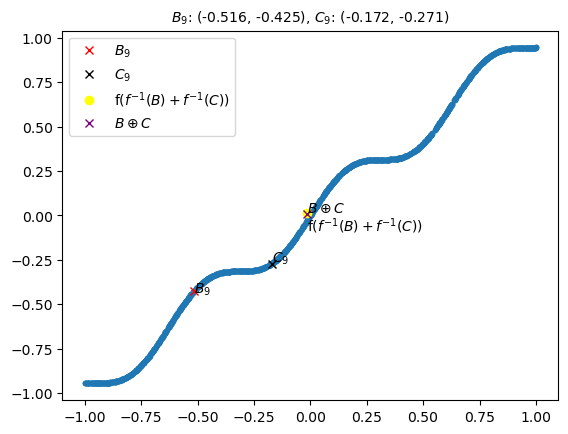

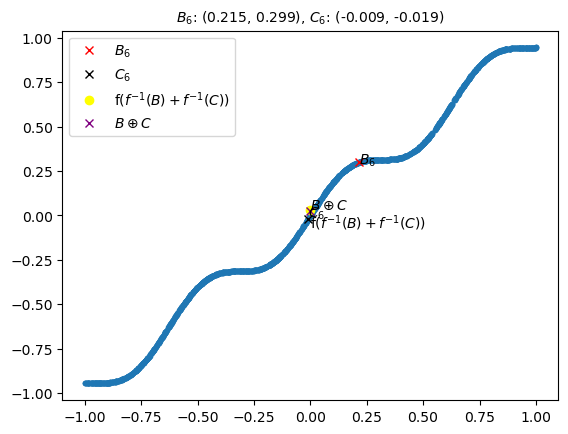

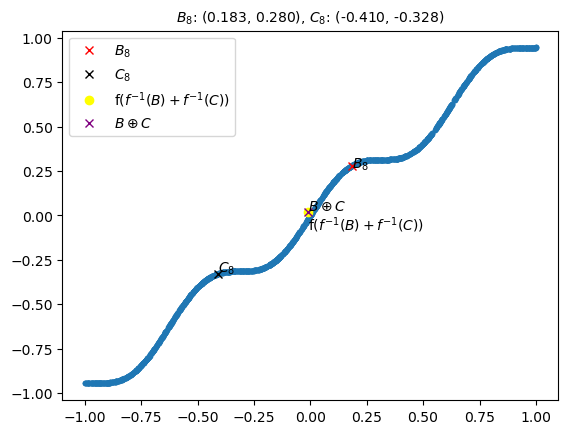

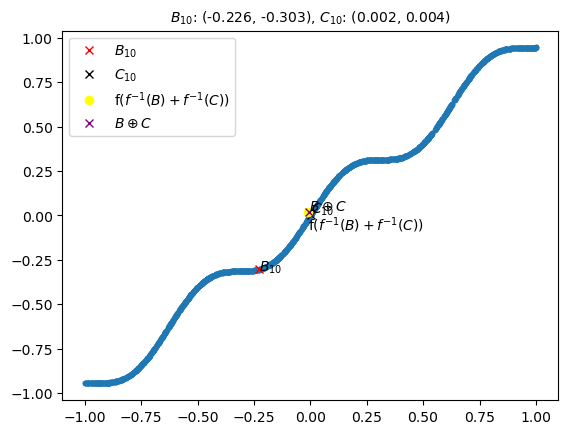

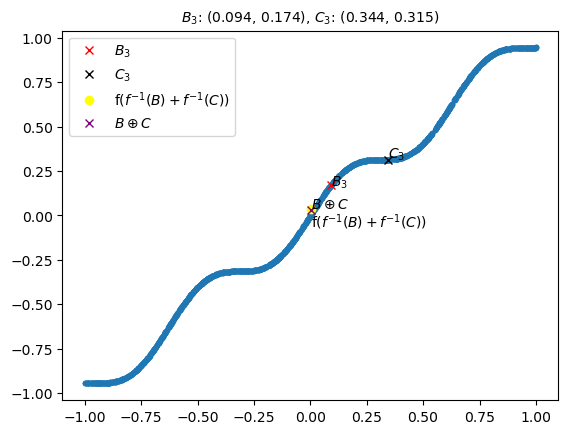

resultat du test de la deuxième propriété du théorème 
               f(α . f^{-1}(B))                         α ⊙ B L^2 erreur  \
0   [-0.010360509, 0.019719366]  [-0.0059165284, 0.021480538]    4.8e-03   
1  [-0.0049371347, 0.025783207]  [-0.0045345873, 0.023320697]    2.5e-03   
2    [0.0031343885, 0.03502384]    [-0.003666602, 0.02330219]    1.4e-02   
3  [-0.0067199655, 0.023822147]    [-0.005936846, 0.02140338]    2.5e-03   
4   [-0.007999878, 0.022266075]  [-0.0075230896, 0.020673357]    1.7e-03   
5  [-0.0051301084, 0.025739133]   [-0.004390344, 0.023376007]    2.5e-03   
6   [-0.0073020793, 0.02296888]  [-0.0026743636, 0.023712933]    4.7e-03   
7  [-0.0014411919, 0.029985338]  [-0.0056670457, 0.022293046]    8.8e-03   
8   [-0.002931185, 0.028311457]  [-0.0027187392, 0.024319153]    4.0e-03   
9   [-0.005184356, 0.025579445]    [-0.00434763, 0.023325838]    2.4e-03   

  inf erreur  
0    4.4e-03  
1    2.5e-03  
2    1.2e-02  
3    2.4e-03  
4    1.6e-03  
5    2.4e-03  
6  

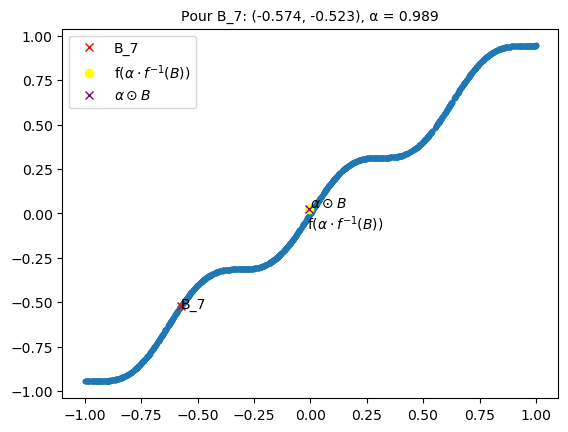

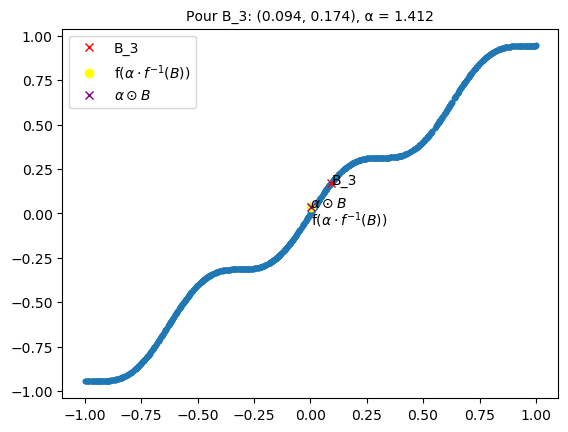

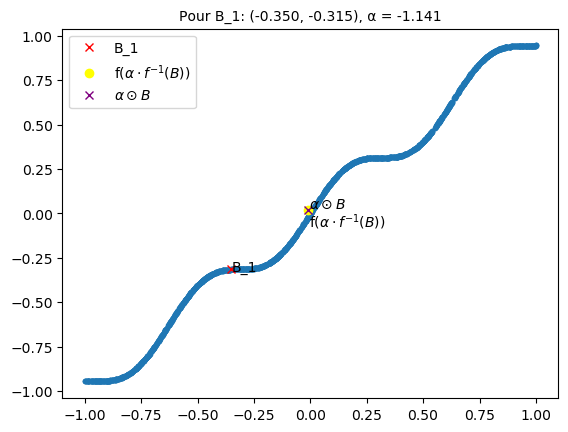

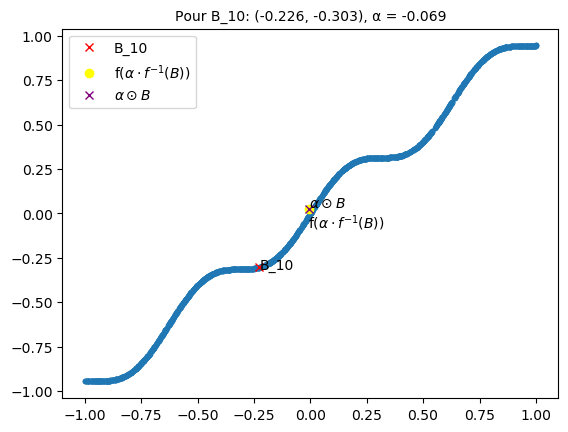

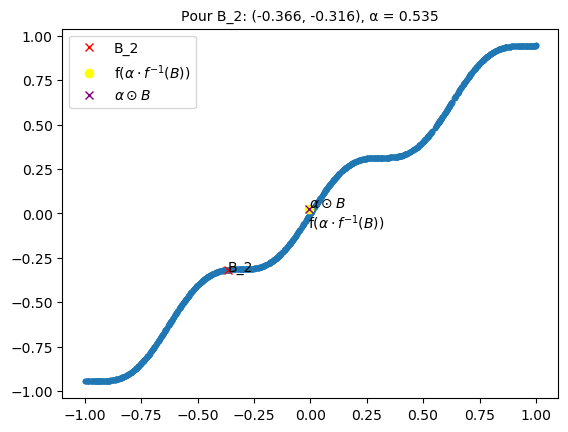

In [17]:
%run base.py --epoch 1000